<a href="https://www.kaggle.com/code/hossamalhelaly/ca-housing-analysis-using-machine-learning?scriptVersionId=128907441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# California Housing

## Project Overview:
* The project is a part of "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", Chapter II "End-to-end Machine Learning Project",  by Aurélien Géron
* This notebook is just a mimic of the project mentioned in the book, however without going through much of the explanation in the book.

### The Big Picture:
* We need to build a model to predict housing prices in California
* The data goes back to 1990s
* The data is grouped into block groups, typically has a population of 600 - 3000 people
* The data includes metrics such as:
    * Population
    * Median income per block
    * Median housing price per block

### Model:
* Regression Models, Linear Regression and KNeighbors Polynomial Regressor

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder


mpl.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Get the Data:

In [2]:
housing = pd.read_csv('/kaggle/input/housingcsv/housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
housing['ocean_proximity'] = housing['ocean_proximity'].astype('category')
housing['ocean_proximity'].dtype

CategoricalDtype(categories=['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], ordered=False)

>Further exploring is needed for `ocean_proximity`

### Getting to know the data:
* We needed to examine the `ocean_proximity` column
* Our model will be a regression model, thus we'd need our data to be numeric
* Appearantly `ocean_proximity` is a categorical data-type column
* We would need `OneHotEncoder()` to *transform* categorical data into boolean data `0`s and `1`s

#### Getting to know the rest of the data:
* the rest of the columns are numerical, hence we could get a glimpse using `.describe()` method  
* and `.hist()` for graphical statistical distribution


In [4]:
housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'housing_median_age'}>],
       [<AxesSubplot: title={'center': 'total_rooms'}>,
        <AxesSubplot: title={'center': 'total_bedrooms'}>,
        <AxesSubplot: title={'center': 'population'}>],
       [<AxesSubplot: title={'center': 'households'}>,
        <AxesSubplot: title={'center': 'median_income'}>,
        <AxesSubplot: title={'center': 'median_house_value'}>]],
      dtype=object)

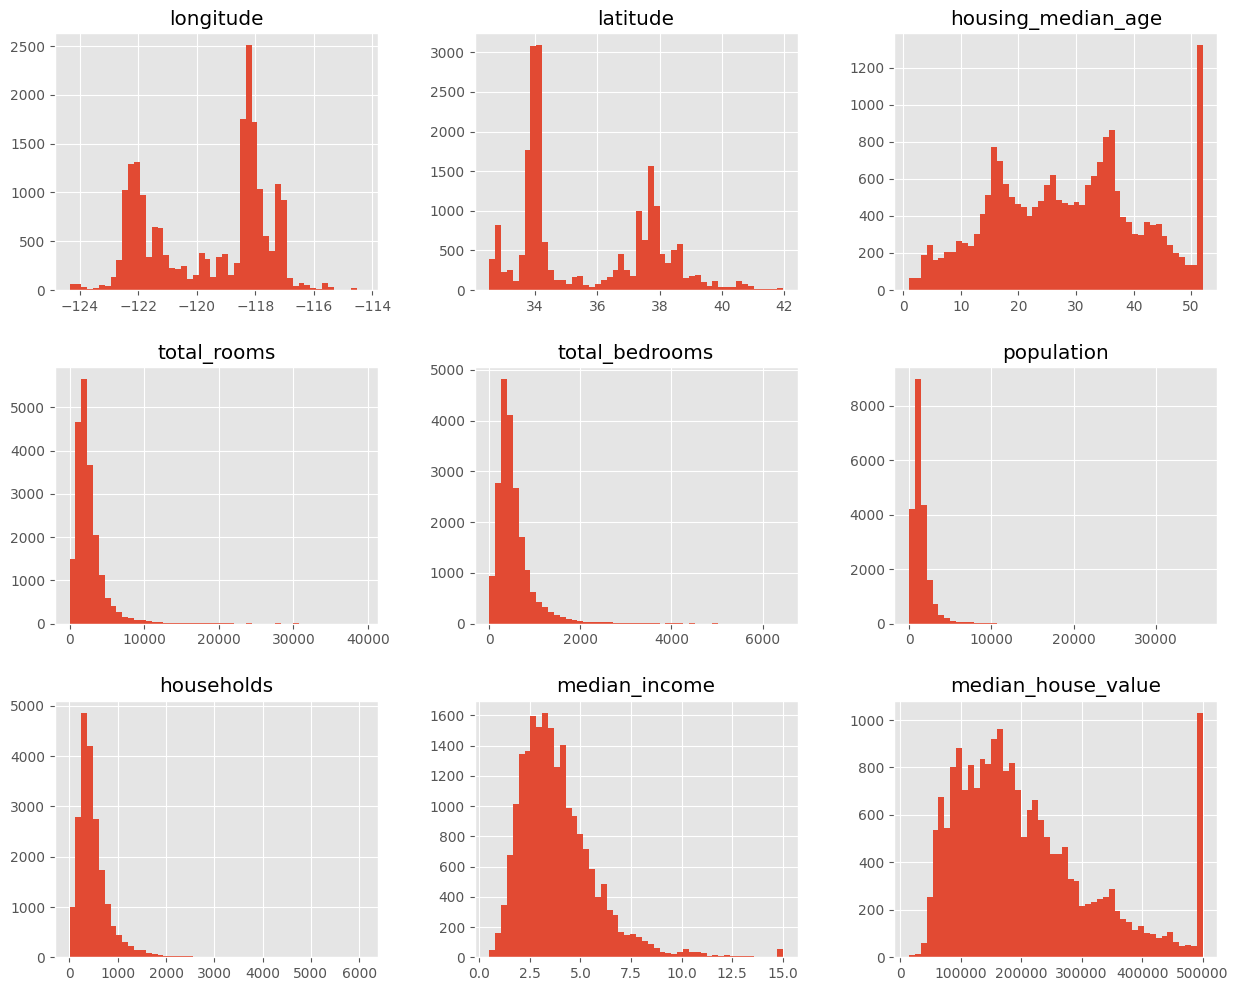

In [5]:
housing.hist(bins = 50, figsize = (15, 12))

## Cleaning the Data:
* Do we have missing values?
* How would we handle them? Why?

> Apparently no need to deal with outliers, we will deal with the data as is 

In [6]:
100 * housing.isna().sum()/housing.count()

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.013067
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

### Answers:
* We can see that 1.013% of `total_bedrooms` feature is missing
* We will replace the missing with the median value.
* Although it's only 1% of the data, but dropping them means loosing a portion of the data, and this is a risk I am not willing to take
* Hence, I will use `.fillna()` method to replace the `Nan`s with the `median` value


In [7]:
#replacing na's
housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace = True)
100 * housing.isna().sum()/housing.count()

longitude             0.0
latitude              0.0
housing_median_age    0.0
total_rooms           0.0
total_bedrooms        0.0
population            0.0
households            0.0
median_income         0.0
median_house_value    0.0
ocean_proximity       0.0
dtype: float64

## Modelling:
* Preparing the sets *(Features, and Labels):
    * Scaling/Rescaling the features 
    * OneHotEncoding categorical data
* Splitting the data
* Choosing a model
* Training the model
* Hyperparameter finetuning
* Evaluating the model


### Preparing the data:

#### One Hot Encoding:
* Will do *One Hot Encoding* using `sklearn.preprocessing.OneHotEncoder()`
* This will transform a categorical feature, in one column, into a number of boolean features, columns, equal to the number of categories 
* Will plot a pair plot of the to make sure that the OHE was correctly run using `.style.background_gradient()`
* Will then drop the `ocean_proximity` feature 

In [8]:
#OneHotEncoding for ocean_proximity

ohe = OneHotEncoder()
ohe_df = pd.DataFrame(ohe.fit_transform(housing[['ocean_proximity']]).toarray())
ohe_df.columns = ['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']

In [9]:
df = housing.join(ohe_df)
df[['ocean_proximity', '<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']].groupby('ocean_proximity').mean().style.background_gradient()

,<1H_OCEAN,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN
ocean_proximity,,,,,
<1H OCEAN,1.000000,0.000000,0.000000,0.000000,0.000000
INLAND,0.000000,1.000000,0.000000,0.000000,0.000000
ISLAND,0.000000,0.000000,1.000000,0.000000,0.000000
NEAR BAY,0.000000,0.000000,0.000000,1.000000,0.000000
NEAR OCEAN,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
#drop the ocean_proximity feature
df.drop('ocean_proximity', axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   <1H_OCEAN           20640 non-null  float64
 10  INLAND              20640 non-null  float64
 11  ISLAND              20640 non-null  float64
 12  NEAR_BAY            20640 non-null  float64
 13  NEAR_OCEAN          20640 non-null  float64
dtypes: float64(14)
memory usage: 2.2 MB


### Creating Features:
* Dropping the label column `median_house_value`, and assigning the values to `X`
* Having the labels assigned to `y`

In [11]:
X = df.drop('median_house_value', axis = 1).values
y = df['median_house_value'].values

print('Features Shape: ', X.shape)
print('Labels Shape: ', y.shape)

Features Shape:  (20640, 13)
Labels Shape:  (20640,)


### Splitting the Data:


In [12]:
sizeScore = {}
sizes = np.arange(0.2, 1, 0.01)
trScorelm = []
tsScorelm = []
for size in sizes:
    Xtr, Xts, ytr, yts = train_test_split(X, y, test_size = size)
    lm = LinearRegression()
    lm.fit(Xtr, ytr)
    sizeScore[size] = lm.score(Xts, yts)
    trScorelm.append(lm.score(Xtr, ytr))
    tsScorelm.append(lm.score(Xts, yts))


optSize = max(sizeScore.items(), key = lambda x: x[1])[0] 
print("Optimum Test Size: ", optSize)
print("Best Testing Accuracy: ", sizeScore[optSize])

Optimum Test Size:  0.25000000000000006
Best Testing Accuracy:  0.6643570924476271


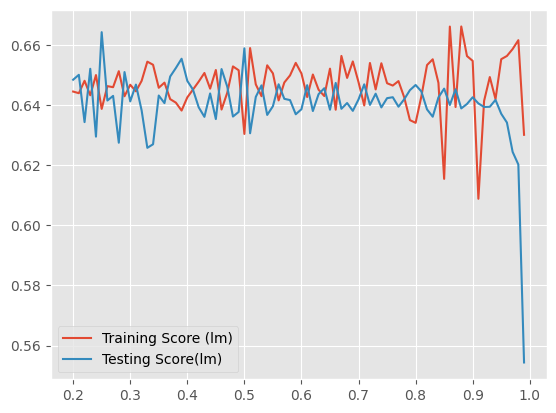

In [13]:
plt.plot(sizes, trScorelm, label = 'Training Score (lm)')
plt.plot(sizes, tsScorelm, label = 'Testing Score(lm)')
plt.legend()


In [14]:
neighborScore = {}
neighbors = np.arange(1, 15, 1)
trScorekr = []
tsScorekr = []
for neighbor in neighbors:
    Xtr, Xts, ytr, yts = train_test_split(X, y, test_size = optSize)
    #repeating for KNN Polynomial Regressor
    kr = KNeighborsRegressor(neighbor)
    kr.fit(Xtr, ytr)
    neighborScore[neighbor] = kr.score(Xts, yts) 
    trScorekr.append(kr.score(Xtr, ytr))
    tsScorekr.append(kr.score(Xts, yts))

optN = max(neighborScore.items(), key = lambda x: x[1])[0] 
print("Optimum Number of  Neighbors: ", optN)
print("Best Testing Accuracy: ", neighborScore[optN])

Optimum Number of  Neighbors:  14
Best Testing Accuracy:  0.33288651853946893


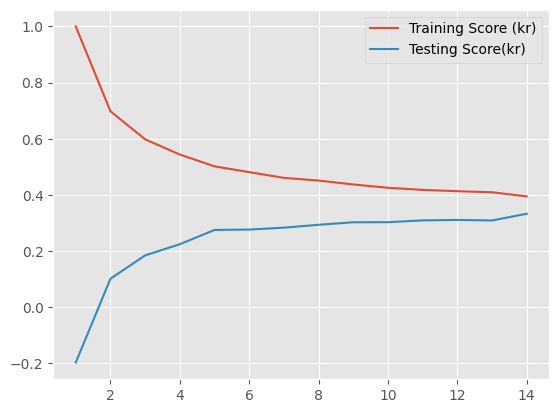

In [15]:
plt.plot(neighbors, trScorekr, label = 'Training Score (kr)')
plt.plot(neighbors, tsScorekr, label = 'Testing Score(kr)')
plt.legend()